# Many-to-Many RNN/LSTM/GRU for Time-series


In [1]:
import os
import json
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
def torch_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

# Dataset

## Download

Bike sharing dataset

- 데이터 출처: https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

In [3]:
!wget https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
!unzip bike+sharing+dataset.zip

--2024-04-17 07:05:17--  https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bike+sharing+dataset.zip’

bike+sharing+datase     [  <=>               ] 273.43K  1.14MB/s    in 0.2s    

2024-04-17 07:05:19 (1.14 MB/s) - ‘bike+sharing+dataset.zip’ saved [279992]

Archive:  bike+sharing+dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


# Load Dataset

학습을 위해 구성할 데이터 구조

<p align="center">
  <img src="https://github.com/TooTouch/BalancedSoftmax/assets/37654013/dba55ab9-92a3-4c02-adc4-b7618fae209d">
</p>

In [4]:
df = pd.read_csv('hour.csv')
df['dteday'] = pd.to_datetime(df['dteday'])
df = df.sort_values(['dteday', 'hr'])

In [5]:
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [6]:
continuous_columns = ['holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']
categorical_columns = ['season', 'weekday', 'weathersit']
df_select = df[continuous_columns+categorical_columns]
df_dummy = pd.get_dummies(df_select, columns=categorical_columns) # dummy transform
df_dummy

,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,0,0,0.24,0.2879,0.81,0.0000,16,True,False,False,...,False,False,False,False,False,True,True,False,False,False
1,0,0,0.22,0.2727,0.80,0.0000,40,True,False,False,...,False,False,False,False,False,True,True,False,False,False
2,0,0,0.22,0.2727,0.80,0.0000,32,True,False,False,...,False,False,False,False,False,True,True,False,False,False
3,0,0,0.24,0.2879,0.75,0.0000,13,True,False,False,...,False,False,False,False,False,True,True,False,False,False
4,0,0,0.24,0.2879,0.75,0.0000,1,True,False,False,...,False,False,False,False,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,0,1,0.26,0.2576,0.60,0.1642,119,True,False,False,...,True,False,False,False,False,False,False,True,False,False
17375,0,1,0.26,0.2576,0.60,0.1642,89,True,False,False,...,True,False,False,False,False,False,False,True,False,False
17376,0,1,0.26,0.2576,0.60,0.1642,90,True,False,False,...,True,False,False,False,False,False,True,False,False,False
17377,0,1,0.26,0.2727,0.56,0.1343,61,True,False,False,...,True,False,False,False,False,False,True,False,False,False


In [7]:
X = df_dummy.drop('cnt', axis=1).values
y = df_dummy['cnt'].values

In [8]:
input_window_size = 6 ##### 수정 #####
output_window_size = 6 ##### 수정 #####
stride = 1
nb_samples = len(X)
nb_window = (nb_samples - input_window_size - output_window_size) + stride + stride ##### 수정 #####

print('input window_size: ',input_window_size) ##### 수정 #####
print('output window_size: ',output_window_size) ##### 수정 #####
print('stride: ',stride)
print('nb_samples: {:,}'.format(nb_samples))
print('nb_window: {:,}'.format(nb_window))

input window_size:  6
output window_size:  6
stride:  1
nb_samples: 17,379
nb_window: 17,369


In [9]:
window_idx = np.arange(nb_window)

In [10]:
valid_len = int(window_idx.shape[0] * 0.2) ##### 수정 #####
test_len = 1 ##### 수정 #####: 미래 여러시점을 예측하는 Task니, 최종 test 시점만 비교

In [11]:
test_window_idx = window_idx[-test_len:]
valid_window_idx = window_idx[-(valid_len+test_len):-test_len]
train_window_idx = window_idx[:-(valid_len+test_len)]

# Create Dataset and DataLoader

In [12]:
continuous_idx = [i for i, c in enumerate(df_dummy.columns) if c in continuous_columns]
continuous_idx

[0, 1, 2, 3, 4, 5, 6]

In [13]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_scaler.fit(X[:-(valid_len+test_len), continuous_idx])

y_scaler = StandardScaler()
y_scaler.fit(y[:-(valid_len+test_len)].reshape(-1,1))

StandardScaler()

In [14]:
class TSDataset(Dataset):
    def __init__(self, X, y, window_idx: np.ndarray, input_window_size: int, output_window_size: int, continuous_idx: list, X_scaler, y_scaler): ##### 수정 #####
        self.X = X
        self.y = y
        self.window_idx = window_idx
        self.input_window_size = input_window_size ##### 수정 #####
        self.output_window_size = output_window_size ##### 수정 #####

        self.X_scaler = X_scaler
        self.y_scaler = y_scaler
        self.continuous_idx = continuous_idx

    def __getitem__(self, i):
        x_selected_idx = self.window_idx[i]
        y_selected_idx = self.window_idx[i] + self.input_window_size - 1 ##### 수정 #####

        x_window = np.arange(self.input_window_size) + x_selected_idx ##### 수정 #####
        y_window = np.arange(self.output_window_size) + y_selected_idx ##### 수정 #####

        x_i = self.X[x_window].astype(np.float32)
        y = self.y[y_window].astype(np.float32) ##### 수정 #####

        # scaling
        x_i[:,self.continuous_idx] = self.X_scaler.transform(x_i[:,self.continuous_idx])
        y = self.y_scaler.transform(y.reshape(-1,1)) ##### 수정 #####

        return x_i, y

    def __len__(self):
        return len(self.window_idx)

In [15]:
trainset = TSDataset(
    X              = X,
    y              = y,
    window_idx     = train_window_idx,
    input_window_size    = input_window_size, ##### 수정 #####
    output_window_size    = output_window_size, ##### 수정 #####
    continuous_idx = continuous_idx,
    X_scaler       = X_scaler,
    y_scaler       = y_scaler
)
validset = TSDataset(
    X              = X,
    y              = y,
    window_idx     = valid_window_idx,
    input_window_size    = input_window_size, ##### 수정 #####
    output_window_size    = output_window_size, ##### 수정 #####
    continuous_idx = continuous_idx,
    X_scaler       = X_scaler,
    y_scaler       = y_scaler
)
testset = TSDataset(
    X              = X,
    y              = y,
    window_idx     = test_window_idx,
    input_window_size    = input_window_size, ##### 수정 #####
    output_window_size    = output_window_size, ##### 수정 #####
    continuous_idx = continuous_idx,
    X_scaler       = X_scaler,
    y_scaler       = y_scaler
)

In [16]:
x_temp, y_temp = trainset[5]

print('x_temp.shape: ',x_temp.shape)
print('y_temp: ',y_temp)

x_temp.shape:  (6, 21)
y_temp:  [[-0.8305471 ]
 [-0.71074444]
 [-0.5430208 ]
 [-0.4831195 ]
 [-0.41123793]
 [-0.3872774 ]]


In [17]:
trainloader = DataLoader(
    dataset     = trainset,
    batch_size  = 256, ##### 수정 #####: 갖고 계신 데이터 절반 개수 정도로 수정해주세요
    shuffle     = True,
)

validloader = DataLoader(
    dataset     = validset,
    batch_size  = 1024, ##### 수정 #####: 갖고 계신 데이터 절반 개수 정도로 수정해주세요
    shuffle     = False,
)

testloader = DataLoader(
    dataset     = testset,
    batch_size  = 1024, ##### 수정 #####: 갖고 계신 데이터 절반 개수 정도로 수정해주세요
    shuffle     = False,
)

In [18]:
inputs, targets = next(iter(trainloader))
inputs, targets = inputs.to('cuda'), targets.to('cuda')
print('inputs.shape: ', inputs.shape)
print('targets.shape: ', targets.shape)

inputs.shape:  torch.Size([256, 6, 21])
targets.shape:  torch.Size([256, 6, 1])


# Build Model

In [19]:
##### 수정 #####: 모델 코드는 전체적으로 수정되었습니다.

### Attention
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()

    def forward(self, hidden, encoder_outputs):
        if len(hidden.shape) == 3: ### LSTM
            hidden_last_layer = hidden[-1]
        elif len(hidden.shape) == 2: ### RNN, GRU
            hidden_last_layer = hidden
        hidden_expanded = hidden_last_layer.unsqueeze(2)
        attention_scores = torch.bmm(encoder_outputs, hidden_expanded).squeeze(2)
        attention_weights = F.softmax(attention_scores, dim=1)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context_vector, attention_weights

### Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, encoder_type='LSTM'):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = getattr(nn, encoder_type)(input_dim, hidden_dim, num_layers, batch_first=True)

    def forward(self, x):
        outputs, hidden = self.rnn(x)
        return outputs, hidden  # 이제 outputs도 반환합니다.

### Decoder
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers, decoder_type='LSTM'):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = getattr(nn, decoder_type)(output_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # context_vector를 포함하기 위해 크기 수정
        self.attention = Attention()

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        output, hidden = self.rnn(input, hidden)
        context_vector, _ = self.attention(hidden[-1], encoder_outputs)
        output = torch.cat((output.squeeze(1), context_vector), dim=1)
        prediction = self.fc(output)
        return prediction, hidden

### Seq2Seq: Many-to-Many RNN with Attention
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg):
        encoder_outputs, hidden = self.encoder(src)
        input = trg[:, 0]
        outputs = torch.zeros(trg.size()).to(self.device)

        for t in range(0, trg.size(1)):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t] = output
            input = output.reshape(-1, 1)

        return outputs

In [20]:
# Instantiate the RNN model
encoder_rnn = Encoder(input_dim=X.shape[1], hidden_dim=64, num_layers=2, encoder_type='RNN') ##### 수정 #####
decoder_rnn = Decoder(output_dim=1, hidden_dim=64, num_layers=2, decoder_type='RNN') ##### 수정 #####
model_rnn = Seq2Seq(encoder_rnn, decoder_rnn, device='cuda').to('cuda') ##### 수정 #####
model_rnn

Seq2Seq(
  (encoder): Encoder(
    (rnn): RNN(21, 64, num_layers=2, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): RNN(1, 64, num_layers=2, batch_first=True)
    (fc): Linear(in_features=128, out_features=1, bias=True)
    (attention): Attention()
  )
)

In [21]:
outputs = model_rnn(inputs, targets) ##### 수정 #####
outputs.shape

torch.Size([256, 6, 1])

# Model Training

In [22]:
def calc_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    return {
        "RMSE" : rmse,
        "MAE"  : mae,
    }

def train(model, trainloader, optimizer, criterion, scaler):
    # train mode
    model.train()

    # device
    device = next(iter(model.parameters())).device

    # results
    all_outputs = []
    all_targets = []
    total_loss = 0

    # progress
    pbar = tqdm(trainloader, total=len(trainloader), desc="[TRAIN]", leave=False)

    # training
    for batch_i, batch in enumerate(pbar):
        inputs, targets = batch

        # device
        inputs, targets = inputs.to(device), targets.to(device)

        # outputs
        outputs = model(inputs, targets) ##### 수정 #####

        # loss
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # compute gradients
        loss.backward()

        # update model parameters using optimizer
        optimizer.step()
        optimizer.zero_grad()

        # stack outputs and targets
        all_outputs.extend(outputs.detach().cpu().tolist())
        all_targets.extend(targets.detach().cpu().tolist())

        # update progress
        pbar.set_description(desc="[TRAIN]: Loss: {loss:7.4f} ({loss_avg:7.4f})".format(
            loss     = loss,
            loss_avg = total_loss / (batch_i+1),
        ))

    all_outputs = np.asarray(all_outputs)
    all_targets = np.asarray(all_targets)

    # inverse transform
    all_outputs = scaler.inverse_transform(all_outputs.reshape(-1, 1)) ##### 수정 #####
    all_targets = scaler.inverse_transform(all_targets.reshape(-1, 1)) ##### 수정 #####

    results = calc_metrics(y_true=all_targets, y_pred=all_outputs)

    return results

def test(model, testloader, criterion, scaler, return_preds: bool = False):
    # evaluation mode
    model.eval()

    # device
    device = next(iter(model.parameters())).device

    # results
    all_outputs = []
    all_targets = []
    total_loss = 0

    # progress
    pbar = tqdm(testloader, total=len(testloader), desc="[TEST]", leave=False)

    # evaluation
    with torch.no_grad():
        for batch_i, batch in enumerate(pbar):
            inputs, targets = batch

            # device
            inputs, targets = inputs.to(device), targets.to(device)

            # outputs
            outputs = model(inputs, targets) ##### 수정 #####

            # loss
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            # stack outputs and targets
            all_outputs.extend(outputs.cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

            # update progress
            pbar.set_description(desc="[TEST]: Loss: {loss:7.4f} ({loss_avg:7.4f})".format(
                loss     = loss,
                loss_avg = total_loss / (batch_i+1),
            ))

    all_outputs = np.asarray(all_outputs)
    all_targets = np.asarray(all_targets)

    # inverse transform
    all_outputs = scaler.inverse_transform(all_outputs.reshape(-1, 1)) ##### 수정 #####
    all_targets = scaler.inverse_transform(all_targets.reshape(-1, 1)) ##### 수정 #####

    results = calc_metrics(y_true=all_targets, y_pred=all_outputs)

    if return_preds:
        return results, all_outputs
    else:
        return results

def fit(model, epochs, trainloader, testloader, criterion, optimizer, scheduler, scaler, savedir: str, seed: int = 223):
    torch_seed(seed)

    # make save directory
    os.makedirs(savedir, exist_ok=True)

    # history
    history = {'train': defaultdict(list), 'test': defaultdict(list)}
    best_rmse = np.inf

    # progress bar
    pbar = tqdm(range(epochs), total=epochs)
    for i in pbar:

        # train
        train_results = train(
            model       = model,
            trainloader = trainloader,
            criterion   = criterion,
            optimizer   = optimizer,
            scaler      = scaler
        )
        # test
        test_results = test(
            model      = model,
            testloader = testloader,
            criterion  = criterion,
            scaler     = scaler
        )

        # update scheduler
        scheduler.step()

        # update progress
        pbar.set_description(desc="[TRAIN] MAE: {mae_train:>7.4f} [TEST] MAE: {mae_test:>7.4f}".format(
            mae_train = train_results['MAE'],
            mae_test  = test_results['MAE']
        ))

        # append history
        for k, v in train_results.items():
            history['train'][k].append(v)

        for k, v in test_results.items():
            history['test'][k].append(v)

        # save best model
        if best_rmse > test_results['MAE']:
            torch.save(model.state_dict(), os.path.join(savedir, 'best_model.pt'))

    # save results
    json.dump(history, open(os.path.join(savedir, 'history.json'), 'w'), indent='\t')

    return history

def history_plot(history: dict):
    # train history table
    df_train_history = pd.DataFrame(history['train'])
    df_train_history['epoch'] = range(len(df_train_history))
    df_train_history['split'] = 'train'

    # test history table
    df_test_history = pd.DataFrame(history['test'])
    df_test_history['epoch'] = range(len(df_test_history))
    df_test_history['split'] = 'test'
    df_history = pd.concat([df_train_history, df_test_history], axis=0)

    # plot
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    for i, m in enumerate(['RMSE', 'MAE']):
        sns.lineplot(
            x    = 'epoch',
            y    = m,
            hue  = 'split',
            data = df_history,
            ax   = ax[i]
        )
        ax[i].set_ylabel(m.upper())
    plt.tight_layout()
    plt.show()

In [23]:
epochs = 3 ##### 수정 #####: 학습 잘 안될 경우, Epoch을 크게 하고, LR을 낮춰주세요
lr = 1e-2 ##### 수정 #####: 학습 잘 안될 경우, Epoch을 크게 하고, LR을 낮춰주세요
eta_min = lr * 1e-2
seed = 223

In [24]:
# Instantiate the RNN model
torch_seed(223)
encoder_rnn = Encoder(input_dim=X.shape[1], hidden_dim=64, num_layers=2, encoder_type='RNN')
decoder_rnn = Decoder(output_dim=1, hidden_dim=64, num_layers=2, decoder_type='RNN')
model_rnn = Seq2Seq(encoder_rnn, decoder_rnn, device='cuda').to('cuda')

encoder_lstm = Encoder(input_dim=X.shape[1], hidden_dim=64, num_layers=2, encoder_type='LSTM')
decoder_lstm = Decoder(output_dim=1, hidden_dim=64, num_layers=2, decoder_type='LSTM')
model_lstm = Seq2Seq(encoder_lstm, decoder_lstm, device='cuda').to('cuda')

encoder_gru = Encoder(input_dim=X.shape[1], hidden_dim=64, num_layers=2, encoder_type='GRU')
decoder_gru = Decoder(output_dim=1, hidden_dim=64, num_layers=2, decoder_type='GRU')
model_gru = Seq2Seq(encoder_gru, decoder_gru, device='cuda').to('cuda')

print('RNN parameters: {:,}'.format(sum([p.numel() for p in model_rnn.parameters()])))
print('LSTM parameters: {:,}'.format(sum([p.numel() for p in model_lstm.parameters()])))
print('GRU parameters: {:,}'.format(sum([p.numel() for p in model_gru.parameters()])))

model_rnn.cuda()
model_lstm.cuda()
model_gru.cuda()
print('convert device to GPU')

RNN parameters: 26,625
LSTM parameters: 106,113
GRU parameters: 79,617
convert device to GPU


In [25]:
# optimizer
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=lr)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=lr)
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=lr)

scheduler_rnn = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_rnn, T_max=epochs, eta_min=eta_min)
scheduler_lstm = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_lstm, T_max=epochs, eta_min=eta_min)
scheduler_gru = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_gru, T_max=epochs, eta_min=eta_min)

# loss function
criterion = nn.L1Loss()

RNN


  0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/55 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/4 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/55 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/4 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/55 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/4 [00:00<?, ?it/s]

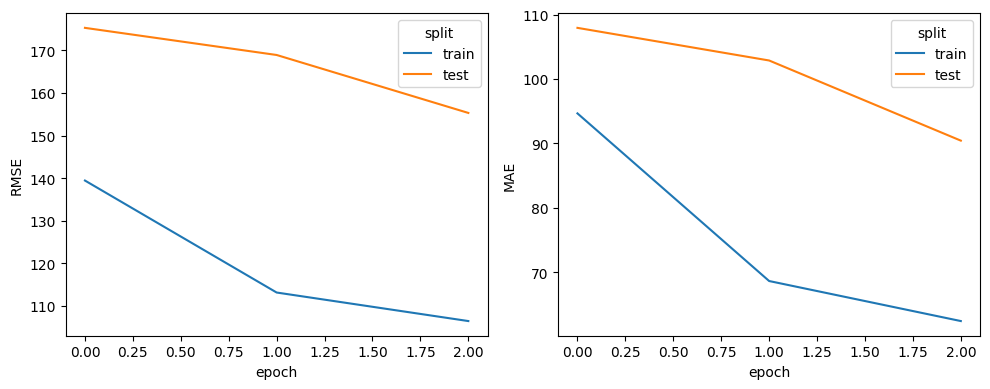

LSTM


  0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/55 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/4 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/55 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/4 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/55 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/4 [00:00<?, ?it/s]

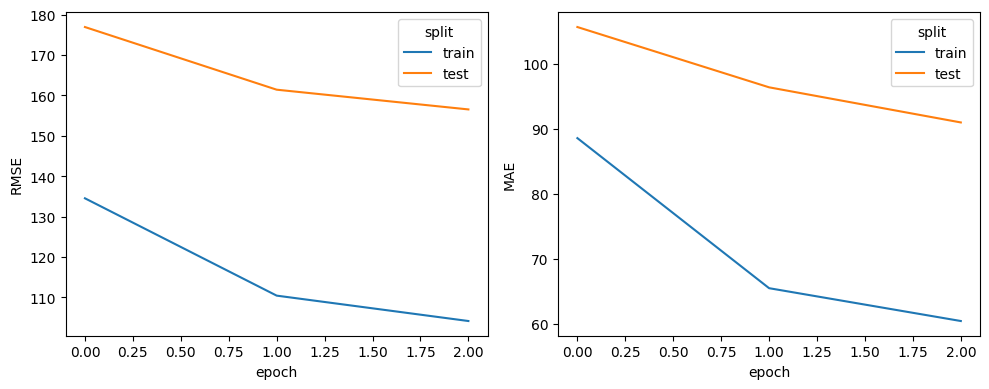

GRU


  0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/55 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/4 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/55 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/4 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/55 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/4 [00:00<?, ?it/s]

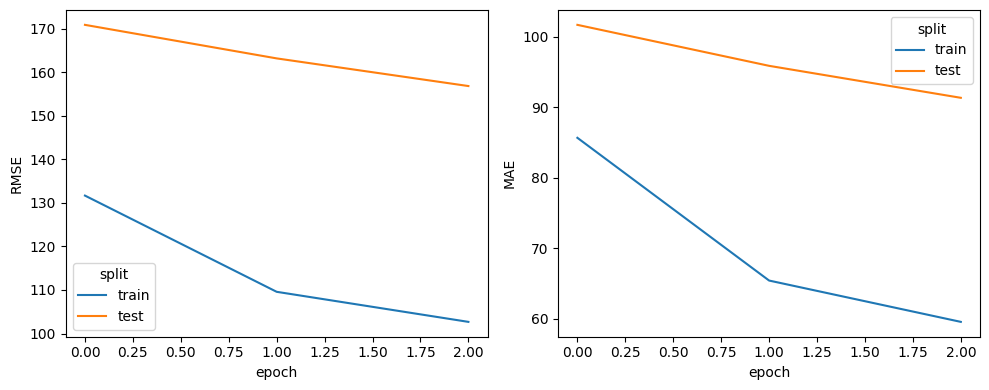

In [26]:
print('RNN')
rnn_history = fit(
    model       = model_rnn,
    epochs      = epochs,
    trainloader = trainloader,
    testloader  = validloader,
    criterion   = criterion,
    optimizer   = optimizer_rnn,
    scheduler   = scheduler_rnn,
    scaler      = y_scaler,
    savedir     = 'saved_model/RNN',
    seed        = seed
)
history_plot(history=rnn_history)

print('LSTM')
lstm_history = fit(
    model       = model_lstm,
    epochs      = epochs,
    trainloader = trainloader,
    testloader  = validloader,
    criterion   = criterion,
    optimizer   = optimizer_lstm,
    scheduler   = scheduler_lstm,
    scaler      = y_scaler,
    savedir     = 'saved_model/LSTM',
    seed        = seed
)
history_plot(history=lstm_history)

print('GRU')
gru_history = fit(
    model       = model_gru,
    epochs      = epochs,
    trainloader = trainloader,
    testloader  = validloader,
    criterion   = criterion,
    optimizer   = optimizer_gru,
    scheduler   = scheduler_gru,
    scaler      = y_scaler,
    savedir     = 'saved_model/GRU',
    seed        = seed
)
history_plot(history=gru_history)



# Test

In [27]:
model_rnn.load_state_dict(torch.load('./saved_model/RNN/best_model.pt'))
model_lstm.load_state_dict(torch.load('./saved_model/LSTM/best_model.pt'))
model_gru.load_state_dict(torch.load('./saved_model/GRU/best_model.pt'))

<All keys matched successfully>

In [28]:
# test
rnn_test_results, rnn_preds = test(
    model        = model_rnn,
    testloader   = testloader,
    criterion    = criterion,
    scaler       = y_scaler,
    return_preds = True
)

# test
lstm_test_results, lstm_preds = test(
    model        = model_lstm,
    testloader   = testloader,
    criterion    = criterion,
    scaler       = y_scaler,
    return_preds = True
)

# test
gru_test_results, gru_preds = test(
    model        = model_gru,
    testloader   = testloader,
    criterion    = criterion,
    scaler       = y_scaler,
    return_preds = True
)

[TEST]:   0%|          | 0/1 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/1 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
results = defaultdict(list)

results['Model'] = ['RNN', 'LSTM', 'GRU']
exp_metrics = [rnn_test_results, lstm_test_results, gru_test_results]
for metrics in exp_metrics:
    for k, v in metrics.items():
        results[k].append(v)

table = pd.DataFrame(results)
table

,Model,RMSE,MAE
0,RNN,18.136285,15.326775
1,LSTM,35.506639,31.767773
2,GRU,18.171695,16.520502


## Figure

In [30]:
df_all = df.iloc[-50:] ##### 수정 #####
df_test = df.iloc[-output_window_size:] ##### 수정 #####

df_test['rnn_pred'] = rnn_preds.reshape(-1) ##### 수정 #####
df_test['lstm_pred'] = lstm_preds.reshape(-1) ##### 수정 #####
df_test['gru_pred'] = gru_preds.reshape(-1) ##### 수정 #####

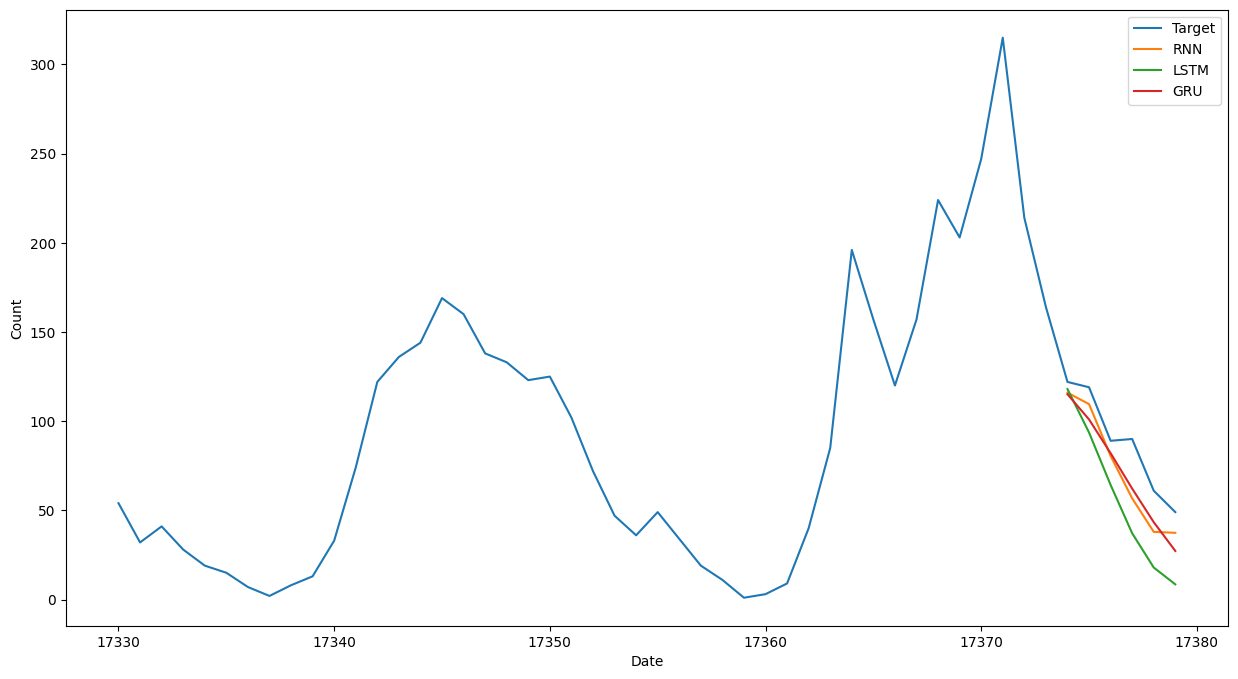

In [31]:
### Figure
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.lineplot(x='instant', y='cnt', data=df_all, label='Target', ax=ax) ##### 수정 #####: x변수명과 y변수명 적절하게 수정해주세요
sns.lineplot(x='instant', y='rnn_pred', data=df_test, label='RNN', ax=ax) ##### 수정 #####
sns.lineplot(x='instant', y='lstm_pred', data=df_test, label='LSTM', ax=ax) ##### 수정 #####
sns.lineplot(x='instant', y='gru_pred', data=df_test, label='GRU', ax=ax) ##### 수정 #####
ax.set_ylabel('Count')
ax.set_xlabel('Date')
plt.show()